PARA PONER EN PRACTICA EL SISTEMA DE RECOMENDACION UTILIZAREMOS EL DATASET MAS CONVENIENTE: RATING_COMPLETE.CSV

Este dataset es un subconjunto de animelist.csv. El mismo, solo considera los animes que el usuario ha visto por completo (watchin_status = 2), y le ha otorgado una puntacion distinta de cero.  
Contiene 57 millones de calificaciones aplicadas a 16.872 animes por 310.059 usuarios. 

In [1]:
#Importamos las librerias que utilizaremos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
rating_complete = pd.read_csv(r"C:\Users\ferbi\OneDrive\Desktop\Fer\DATASCIENCE\Cuarto TP Sistemas de recomendacion\archive (10)\rating_complete.csv")

In [3]:
rating_complete.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [4]:
rating_complete.shape

(57633278, 3)

Tenemos un dataset con 57.633.278 entradas

In [5]:
rating_complete.isna().sum() #No hay elementos nulos 

user_id     0
anime_id    0
rating      0
dtype: int64

INFORMACION DE ATRIBUTOS
1. user_id: ID de cada usuario.
2. anime_id: ID de cada anime.
3. rating: calificaciones asignadas por los usuarios.

In [6]:
#Exploramos rapidamente la columna user_id
rating_complete.user_id.nunique()

310059

Tenemos 310.059 usuarios diferentes

In [7]:
#Exploramos rapidamente la columna anime_id
rating_complete.anime_id.nunique()

16872

Tenemos 16.872 animes diferentes

In [8]:
#Exploramos rapidamente la columna rating
rating_complete.rating.nunique()

10

In [9]:
rating_complete.rating.unique()

array([ 9,  5,  7,  8, 10,  6,  4,  3,  2,  1], dtype=int64)

Tenemos 10 puntuaciones diferentes

Verificamos cuantos usuarios vieron unicamente un solo anime:

In [11]:
# Contamos la cantidad de animes vistos por cada usuario
anime_count = rating_complete.groupby('user_id')['anime_id'].nunique()

# Filtramos usuarios que han visto exactamente un anime
users_with_one_anime = anime_count[anime_count == 1]

# Mostramos el resultado
print("Usuarios con un único anime visto:")
print(users_with_one_anime)

Usuarios con un único anime visto:
user_id
31        1
71        1
92        1
105       1
199       1
         ..
352939    1
353035    1
353306    1
353307    1
353347    1
Name: anime_id, Length: 5952, dtype: int64


Que porcentaje del total de usuarios vio unicamente un solo anime?

In [12]:
# Calculamos el porcentaje
percentage_users_with_one_anime = len(users_with_one_anime) / len(anime_count) * 100

# Mostramos el resultado
print(f"Porcentaje de usuarios que vieron un único anime: {percentage_users_with_one_anime:.2f}%")

Porcentaje de usuarios que vieron un único anime: 1.92%


Veamos que porcentaje de usuarios vieron menos de 5 animes: 

In [13]:
# Filtrar usuarios que han visto menos de 5 animes
users_with_few_animes = anime_count[anime_count < 5]

# Calcular el porcentaje
percentage_users_with_few_animes = len(users_with_few_animes) / len(anime_count) * 100

# Mostrar el resultado
print(f"Porcentaje de usuarios que vieron menos de 5 animes: {percentage_users_with_few_animes:.2f}%")

Porcentaje de usuarios que vieron menos de 5 animes: 5.23%


Divdimos el dataset en conjuntos de train y test. En nuestro caso, no tenemos fechas a partir de las cuales podemos dividir los conjuntos, por lo cual lo haremos de manera aleatoria. 

In [14]:
from sklearn.model_selection import train_test_split

In [11]:
df_train, df_test = train_test_split(rating_complete, test_size=0.2, random_state=42)

In [12]:
df_train.head()

,user_id,anime_id,rating
48863900,299494,2994,8
33147285,203557,32282,8
8872094,54320,7598,10
33765475,207357,16498,9
49256811,301948,16067,9


In [13]:
df_train.shape #Tenemos un conjunto de entrenamiento con 46.106.622 entradas

(46106622, 3)

In [14]:
df_train.user_id.nunique() #En el set de train tenemos 308.673 usuarios diferentes

308673

In [15]:
df_test.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [16]:
df_test.shape #Tenemos un conjunto de testeo con 11.526.656 entradas

(11526656, 3)

In [17]:
df_test.user_id.nunique() #En el set de test tenemos 296.392 usuarios diferentes 

296392

Busquemos si existen usuarios que aparecen en el set de test pero no en el set de train. A estos usuarios debemos recomendarle luego, utilizando COLD STAR

In [18]:
df_test[~df_test.user_id.isin(df_train.user_id.unique())].user_id.nunique()

1386

Tenemos 1.386 usuarios que aparecen en el set de test pero no en el de train

Armamos la matriz de interacciones: 

In [19]:
rating_complete.head(1)

,user_id,anime_id,rating
0,0,430,9


In [20]:
matrix_columns = ['user_id', 'anime_id', 'rating']

In [21]:
interactions = df_train[matrix_columns]
interactions.head()

,user_id,anime_id,rating
48863900,299494,2994,8
33147285,203557,32282,8
8872094,54320,7598,10
33765475,207357,16498,9
49256811,301948,16067,9


In [22]:
interactions.shape

(46106622, 3)

Luego de reiterados intentos de obtener la matriz de interacciones con el total de los datos y sin lograrlo, decidimos reducir el dataset.
El valor maximo para el cual nuestras computadoras logran obtener la matriz de interacciones es igual al total de datos del dataset original / 200

In [15]:
# Establecemos una semilla para reproducibilidad
semilla = 42

In [16]:
# Seleccionamos de forma aleatoria el 1/200 de los datos
np.random.seed(semilla)
rating_reducido = rating_complete.sample(frac=1/200, random_state=semilla)

In [17]:
# Verificar el tamaño del nuevo conjunto de datos reducido
print("Tamaño del conjunto de datos reducido:", rating_reducido.shape)


Tamaño del conjunto de datos reducido: (288166, 3)


In [18]:
rating_reducido.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [19]:
rating_reducido.user_id.nunique() #El dataset reducido contiene 139.983 usuarios diferentes

139983

In [20]:
rating_reducido.anime_id.nunique() #El dataset reducido contiene 10.162 animes diferentes

10162

Veamos en este set de datos, que porcentaje de usuarios vieron unicamente un anime: 

In [28]:
# Contamos la cantidad de animes vistos por cada usuario
anime_count = rating_reducido.groupby('user_id')['anime_id'].nunique()

# Filtramos usuarios que han visto exactamente un anime
users_with_one_anime = anime_count[anime_count == 1]

# Calculamos el porcentaje
percentage_users_with_one_anime = len(users_with_one_anime) / len(anime_count) * 100

# Mostramos el resultado
print(f"Porcentaje de usuarios que vieron un único anime: {percentage_users_with_one_anime:.2f}%")

Porcentaje de usuarios que vieron un único anime: 51.74%


In [21]:
df_train, df_test = train_test_split(rating_reducido, test_size=0.2, random_state=42)

In [22]:
df_train.shape

(230532, 3)

In [23]:
df_train.user_id.nunique() #El set de train contiene 124.061 usuarios diferentes

124061

In [24]:
df_test.shape

(57634, 3)

In [25]:
df_test.user_id.nunique() #El set de test contiene 46.625 usuarios diferentes

46625

In [26]:
usuarios_cold_start = df_test[~df_test.user_id.isin(df_train.user_id.unique())].user_id.nunique()
usuarios_cold_start

15922

Tenemos 15.922 usuarios que aparecen en el set de test pero no en el de train 

In [27]:
#Veamos a que porcentaje del total de usuarios corresponde este valor:
porcentaje_cold_start = usuarios_cold_start*100/rating_reducido.shape[0]
porcentaje_cold_start

5.525287507894755

El 5.53% del total de usuarios seran usuarios COLD START

 Armamos la matriz de interacciones

In [36]:
matrix_columns = ['user_id', 'anime_id', 'rating']

In [37]:
interactions = df_train[matrix_columns]
interactions.head()

,user_id,anime_id,rating
16577859,101789,22319,8
21228456,130497,3686,5
20438581,125686,12413,7
50775800,311313,12365,8
30994970,190382,513,7


In [38]:
#Reseteamos los indices
interactions = interactions.reset_index(drop=True)

In [39]:
interactions.head()

,user_id,anime_id,rating
0,101789,22319,8
1,130497,3686,5
2,125686,12413,7
3,311313,12365,8
4,190382,513,7


In [40]:
#Verificamos si existen filas duplicadas
duplicate_rows = interactions[interactions.duplicated(subset=['user_id', 'anime_id'], keep=False)]
print(duplicate_rows)

Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


No existen filas duplicadas 

In [41]:
interactions_matrix = interactions.pivot(index='user_id', columns='anime_id', values='rating')

In [42]:
interactions_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,45567,45574,45598,45615,45753,46491,47307,47398,47402,47616
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#Completamos los NaN con 0s
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,45567,45574,45598,45615,45753,46491,47307,47398,47402,47616
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
interactions_matrix.shape #Tiene 124.061 filas (usuarios) y 9654 columnas (animes)

(124061, 9654)

Vamos a transformar esta matriz sparsa a una matriz csr matrix (compressed sparse row)

In [45]:
from scipy.sparse import csr_matrix

In [46]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

In [47]:
interactions_matrix_csr

<124061x9654 sparse matrix of type '<class 'numpy.float64'>'
	with 230532 stored elements in Compressed Sparse Row format>

La siguiente celda generara un diccionario que nos servira mas adelante como indice. Tiene como keys el id de cada usuario y como valor el indice (numero de fila de la matriz)

In [48]:
interactions_matrix.index

Index([     0,      6,      7,     19,     21,     22,     28,     33,     37,
           38,
       ...
       353378, 353381, 353383, 353384, 353385, 353386, 353387, 353388, 353395,
       353398],
      dtype='int64', name='user_id', length=124061)

In [49]:
user_ids = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_ids:
    user_dict[i] = counter
    counter += 1

In [50]:
user_dict

{0: 0,
 6: 1,
 7: 2,
 19: 3,
 21: 4,
 22: 5,
 28: 6,
 33: 7,
 37: 8,
 38: 9,
 40: 10,
 41: 11,
 42: 12,
 44: 13,
 47: 14,
 49: 15,
 54: 16,
 55: 17,
 73: 18,
 85: 19,
 90: 20,
 91: 21,
 94: 22,
 101: 23,
 103: 24,
 107: 25,
 108: 26,
 111: 27,
 112: 28,
 117: 29,
 119: 30,
 120: 31,
 121: 32,
 122: 33,
 123: 34,
 124: 35,
 127: 36,
 128: 37,
 129: 38,
 131: 39,
 133: 40,
 135: 41,
 136: 42,
 137: 43,
 146: 44,
 147: 45,
 154: 46,
 156: 47,
 158: 48,
 162: 49,
 163: 50,
 172: 51,
 173: 52,
 174: 53,
 177: 54,
 179: 55,
 184: 56,
 185: 57,
 193: 58,
 194: 59,
 196: 60,
 198: 61,
 207: 62,
 209: 63,
 211: 64,
 214: 65,
 216: 66,
 219: 67,
 221: 68,
 222: 69,
 227: 70,
 228: 71,
 229: 72,
 231: 73,
 238: 74,
 240: 75,
 243: 76,
 244: 77,
 246: 78,
 247: 79,
 251: 80,
 258: 81,
 259: 82,
 260: 83,
 262: 84,
 264: 85,
 267: 86,
 269: 87,
 272: 88,
 277: 89,
 278: 90,
 281: 91,
 286: 92,
 288: 93,
 290: 94,
 293: 95,
 296: 96,
 297: 97,
 304: 98,
 306: 99,
 311: 100,
 313: 101,
 320: 102,
 32

Modelado: ya tenemos la matriz lista para entrenar el modelo. Utilizaremos la libreria LFM (light fm)

In [51]:
pip install lightfm 

In [52]:
from lightfm import LightFM

c:\Users\ferbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Utilizamos para entrenar el primer modelo y como prueba los siguientes parametros: 
- no_components: 3 (caracteristicas latentes)
- random_state: 100 (semilla)
- learning_rate: 0.03 (controla cuanto se ajustan los parametros del modelo en cada paso del entrenamiento)

In [53]:
model = LightFM(no_components=3, random_state=100, learning_rate=0.03)

Entrenamos el modelo con la matriz comprimida por 10 epochs:    

In [54]:
%%time 
#Devuelve el tiempo que le lleva a mi maquina el entrenamiento
model = model.fit(interactions_matrix_csr, epochs = 10)

CPU times: total: 1.05 s
Wall time: 2.13 s


Generamos una prediccion "manual" para el usuario numero 6:

In [55]:
user_x = user_dict[6]
print(user_x)
n_users, n_items = interactions_matrix.shape
print(n_users, n_items)
items_ids = np.arange(n_items)
items_ids 

1
124061 9654


array([   0,    1,    2, ..., 9651, 9652, 9653])

In [56]:
#Generamos las predicciones
preds = model.predict(user_ids= user_x, item_ids = items_ids)
preds

array([2.4598477 , 1.7341185 , 2.0304065 , ..., 0.39393908, 0.4271939 ,
       0.516116  ], dtype=float32)

Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 6. Podemos ordenarlo y obtener las mejores recomendaciones

In [57]:
scores  = pd.Series(preds)
scores.index = interactions_matrix.columns
recomms_6 = list(pd.Series(scores.sort_values(ascending=False).index))[:20] #Obtenemos las primeras 20

In [58]:
scores.index

Index([    1,     5,     6,     7,     8,    15,    16,    17,    18,    19,
       ...
       45567, 45574, 45598, 45615, 45753, 46491, 47307, 47398, 47402, 47616],
      dtype='int64', name='anime_id', length=9654)

In [59]:
recomms_6

[1535,
 11757,
 16498,
 4224,
 6547,
 22319,
 199,
 1575,
 30276,
 20,
 10620,
 19815,
 20507,
 9253,
 5114,
 2904,
 32281,
 31964,
 31043,
 11111]

Ahora chequeemos, que habia visto el usuario 6 en el set de train?

In [60]:
mask = df_train.user_id == 6
df_train[mask].anime_id.unique()

array([1121,  276], dtype=int64)

Verifiquemos si ya habia visto algunos de los contenidos que le estamos recomendando.

In [61]:
df_train[(df_train.user_id == 6) & (df_train.anime_id.isin(recomms_6))].anime_id.unique()

array([], dtype=int64)

En este caso, no estamos recomendando al usuario 6 contenido que ya vio...
Pero, en un sistema de filtro colaborativo siempre puede pasar que el modelo nos recomiende algún item que el usuario ya vió. También puede pasar que nos recomiende algún item que no queremos recomendar por alguna razon. Puede ser alguna restricción del negocio, un contenido que no estará disponible más adelante, etc.

Por todo esto, es importante siempre pedirle al modelo que nos genere más recomendaciones de las que queremos mostrarle al usuario. Por ejemplo, si a nuestros usuarios queremos mostrarles 10 recomendaciones, al sistema le podríamos pedir que nos recomiende 50. Luego, sobre estas 50 recomms aplicamos filtros (contenidos ya vistos, contenidos que no queremos recomendar, etc) y podrían quedarnos por ejemplo unas 30 recomendaciones. De estas 30 tomamos las mejores 10 y nos aseguramos de que siempre le vamos a estar recomendando 10 items al usuario.

Si nosotros le pedimos al modelo únicamente 10 recomendaciones, luego de aplicar los filtros nos pueden quedar pocas (o ninguna) recomm.


COLD START: 
Que pasa con los usuarios que no tenemos en el set de train?
Podemos recomendarle, por ejemplo, los contenidos mas populares... 
Para esto, basandonos en el set de train vamos a generar un dataset ordenado por popularidad.

In [62]:
df_train.head()

,user_id,anime_id,rating
16577859,101789,22319,8
21228456,130497,3686,5
20438581,125686,12413,7
50775800,311313,12365,8
30994970,190382,513,7


In [63]:
df_train.groupby("anime_id", as_index=False).agg({'user_id':'nunique'})

,anime_id,user_id
0,1,332
1,5,132
2,6,201
3,7,41
4,8,10
...,...,...
9649,46491,1
9650,47307,1
9651,47398,4
9652,47402,4


In [64]:
#Obtenemos una lista con los 10 contenidos mas populares:
popularity_df = df_train.groupby("anime_id", as_index=False).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
popularity_df.columns = ['anime_id', 'popularity']
popularity_df.head(10)

,anime_id,popularity
1327,1535,734
5494,16498,711
4914,11757,696
2985,4224,605
3674,6547,581
1362,1575,548
6126,22319,538
6864,30276,538
176,199,524
10,20,516


In [65]:
popularity_df = popularity_df.head(10)

Veamos cuales son esos 10 contenidos mas populares. Para esto, necesitaremos cargar el dataset que contiene los nombres de los animes.

In [66]:
#Obtenemos una lista con los 10 contenidos mas populares:
popular_content = popularity_df.anime_id.values[:10]
popular_content

array([ 1535, 16498, 11757,  4224,  6547,  1575, 22319, 30276,   199,
          20], dtype=int64)

In [67]:
anime = pd.read_csv(r"C:\Users\ferbi\OneDrive\Desktop\Fer\DATASCIENCE\Cuarto TP Sistemas de recomendacion\archive (10)\anime.csv")

In [68]:
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [69]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [70]:
#Nos quedamos con las columnas que nos interesan: 
anime = anime.drop(['Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'], axis=1)

In [71]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name'], dtype='object')

In [72]:
anime.head()

,MAL_ID,Name,Score,Genres,English name
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster


In [73]:
# Realizamos la unión por las columnas 'anime_id' y 'MAL_ID'
merged_df = pd.merge(popularity_df, anime, left_on='anime_id', right_on='MAL_ID')
merged_df

,anime_id,popularity,MAL_ID,Name,Score,Genres,English name
0,1535,734,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",Death Note
1,16498,711,16498,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan
2,11757,696,11757,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online
3,4224,605,4224,Toradora!,8.24,"Slice of Life, Comedy, Romance, School",Toradora!
4,6547,581,6547,Angel Beats!,8.15,"Action, Comedy, Drama, School, Supernatural",Angel Beats!
5,1575,548,1575,Code Geass: Hangyaku no Lelouch,8.72,"Action, Military, Sci-Fi, Super Power, Drama, ...",Code Geass:Lelouch of the Rebellion
6,22319,538,22319,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",Tokyo Ghoul
7,30276,538,30276,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",One Punch Man
8,199,524,199,Sen to Chihiro no Kamikakushi,8.83,"Adventure, Supernatural, Drama",Spirited Away
9,20,516,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",Naruto


In [74]:
# Eliminamos columna duplicada de identidad 
merged_df = merged_df.drop('MAL_ID', axis=1)


In [75]:
merged_df

,anime_id,popularity,Name,Score,Genres,English name
0,1535,734,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",Death Note
1,16498,711,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan
2,11757,696,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online
3,4224,605,Toradora!,8.24,"Slice of Life, Comedy, Romance, School",Toradora!
4,6547,581,Angel Beats!,8.15,"Action, Comedy, Drama, School, Supernatural",Angel Beats!
5,1575,548,Code Geass: Hangyaku no Lelouch,8.72,"Action, Military, Sci-Fi, Super Power, Drama, ...",Code Geass:Lelouch of the Rebellion
6,22319,538,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",Tokyo Ghoul
7,30276,538,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",One Punch Man
8,199,524,Sen to Chihiro no Kamikakushi,8.83,"Adventure, Supernatural, Drama",Spirited Away
9,20,516,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",Naruto


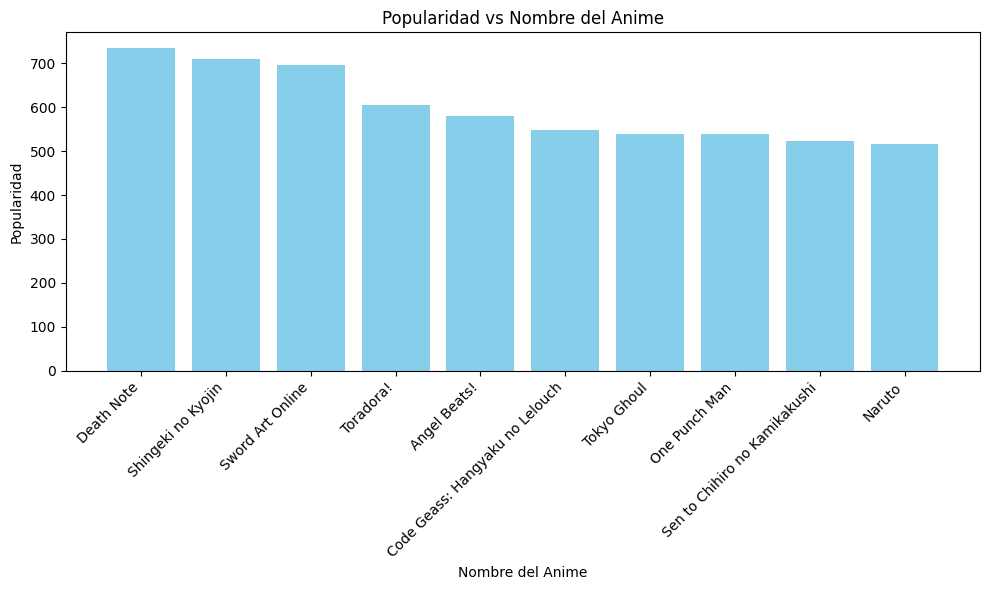

In [76]:
# Graficamos los animes mas populares 
plt.figure(figsize=(10, 6))
plt.bar(merged_df['Name'], merged_df['popularity'], color='skyblue')
plt.xlabel('Nombre del Anime')
plt.ylabel('Popularidad')
plt.title('Popularidad vs Nombre del Anime')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Ahora, basandonos en el ejemplo anterior, vamos a generar 20 recomendaciones para todos los usuarios.
Debemos tener en cuenta:
- Filtrar contenido que el usuario vio anteriormente
- Si el usuario no esta en el set de train, recomendarle los 20 contenidos mas populares

In [77]:
interactions_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,45567,45574,45598,45615,45753,46491,47307,47398,47402,47616
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
interactions_matrix.shape

(124061, 9654)

In [79]:
interactions_matrix.index

Index([     0,      6,      7,     19,     21,     22,     28,     33,     37,
           38,
       ...
       353378, 353381, 353383, 353384, 353385, 353386, 353387, 353388, 353395,
       353398],
      dtype='int64', name='user_id', length=124061)

In [ ]:
from tqdm import tqdm

# Definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold_start': [],  # Nueva columna para indicar si es cold start
    'watched_content': []  # Nueva columna para contener el contenido que el usuario ya vio
}

# Obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

# Por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(df_test.user_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
        # Si el usuario está en train, no es cold start. Usamos el modelo para recomendar
        user_x = user_dict[user]  # Buscamos el índice del usuario en la matriz (transformamos id a índice)

        # Generar las predicciones para el usuario x
        preds = model.predict(user_ids=user_x, item_ids=item_ids)

        # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

        # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = df_train[df_train.user_id == user].anime_id.unique()

        # Filtrar contenidos ya vistos y quedarse con los primeros 10
        recomms = [x for x in scores if x not in watched_contents][:10]

        # Guardamos las recomendaciones en el diccionario y marcamos que no es cold start
        recomms_dict['user_id'].append(user)
        recomms_dict['recomms'].append(scores)
        recomms_dict['cold_start'].append(False)
        recomms_dict['watched_content'].append(watched_contents)
    else:
        # Tratamos a los usuarios que no están en la matriz (cold start)
        recomms_dict['user_id'].append(user)
        # Les recomendamos contenido popular
        recomms_dict['recomms'].append(popular_content)
        recomms_dict['cold_start'].append(True)
        recomms_dict['watched_content'].append([])

# Convertir el diccionario a un DataFrame
recomms_df = pd.DataFrame(recomms_dict)


  0%|          | 0/46625 [00:00<?, ?it/s]

100%|██████████| 46625/46625 [10:26<00:00, 74.39it/s]


In [ ]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms,cold_start,watched_content
0,178593,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",False,[23281]
1,348211,"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ...",False,"[20709, 28623, 17875, 38101]"
2,43693,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",False,"[31646, 467, 5]"
3,306146,"[1535, 16498, 11757, 6547, 4224, 199, 30276, 1...",False,[9750]
4,228292,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
...,...,...,...,...
46620,14910,"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ...",False,"[14045, 11843, 2594, 5984]"
46621,143540,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46622,282331,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46623,35516,"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ...",False,[24833]


Vemos que nuestro sistema No es muy bueno ya que a todos les recomienda en primer lugar el contenido 1535 (el más popular). Además, a la mayoría de los usuarios les estamos dando recomendaciones de cold start. Esto puede deberse a varias razones que pueden ser: el tamaño del dataset (que sea pequeño), parametros mal seleccionados para el modelo, epocas mal seleccionadas, entre otros. 

In [ ]:
#Veamos cuantos usuarios unicos tengo
recomms_df.user_id.nunique() 

46625

In [ ]:
#Veamos la cantidad de usuarios cold start y usuarios que no lo son
recomms_df.cold_start.value_counts()

cold_start
False    30703
True     15922
Name: count, dtype: int64

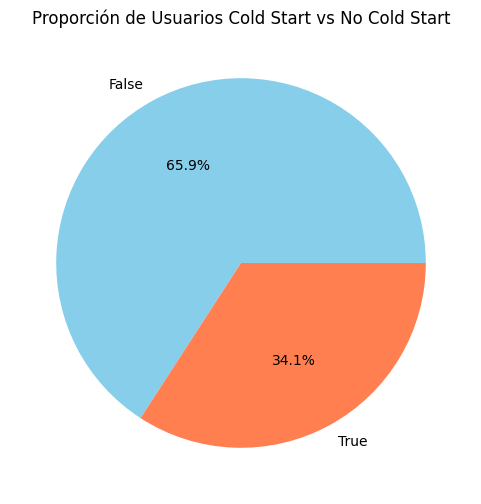

In [ ]:
cold_start_counts = recomms_df['cold_start'].value_counts()

# Crear un gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie(cold_start_counts, labels=cold_start_counts.index, autopct='%1.1f%%', colors=['skyblue', 'coral'])
plt.title('Proporción de Usuarios Cold Start vs No Cold Start')
plt.show()

EVALUACION DE METRICAS

Compararemos nuestras recomendaciones contra las que los usuarios realemnte vieron (set de test)

In [87]:
df_test.head()

,user_id,anime_id,rating
29015932,178593,6987,7
56787266,348211,9790,6
7122641,43693,849,7
49946382,306146,853,10
37180130,228292,35145,10


In [88]:
df_test.shape

(57634, 3)

In [89]:
df_test.user_id.nunique()

46625

Primero ordenamos los animes segun los ratings (de mayor a menor) que dieron los usuarios en el set de testeo. Luego, agrupamos y arnamamos un lsitado de animes para cada usuario. Este sera el listado "ideal" contra el que vams a comparar nuestras recomendaciones.

In [90]:
ideal_recomms = df_test\
                  .sort_values(by=["user_id", "rating", "anime_id"], ascending=False)\
                  .groupby(["user_id"], as_index=False)\
                  .agg({"anime_id": lambda x: list(x.unique())})

In [91]:
ideal_recomms.head()

,user_id,anime_id
0,16,"[21561, 1157]"
1,17,[8086]
2,19,"[10218, 586]"
3,21,[1889]
4,42,"[13759, 10380, 23057]"


In [92]:
ideal_recomms.shape #Tenemos un conjunto de datos que muestra las recmendaciones
#ideales para cada uno de los usuarios del conjunto de testeo

(46625, 2)

Vamos a medir MAP: 
Primero unimos en un mismo dataframe las recomndaciones con el set ideal.

In [ ]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,16,"[21561, 1157]","[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
1,17,[8086],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
2,19,"[10218, 586]","[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
3,21,[1889],"[1535, 16498, 11757, 6547, 4224, 22319, 1575, ..."
4,42,"[13759, 10380, 23057]","[16498, 1535, 11757, 6547, 4224, 1575, 30276, ..."


In [ ]:
df_map.tail()

,user_id,ideal,recomms
46620,353358,[31741],"[16498, 1535, 11757, 6547, 4224, 1575, 30276, ..."
46621,353365,"[24833, 5112]","[16498, 1535, 11757, 6547, 4224, 30276, 1575, ..."
46622,353382,[37510],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
46623,353395,[1882],"[11757, 1535, 16498, 4224, 6547, 199, 20, 3027..."
46624,353398,[33532],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."


In [ ]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [ ]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.00276


Vemos que la metrica nos da un valor muy bajo, por lo tanto el modelo dando buenas recomendaciones

--------------------------------------------------------------------------

Probamos con diferentes parametros utilizando GridSearchCV  
Esta celda aparece comentada para que no vuelva a ejecutarse cada vez que trabajamos en esta notebook. 

In [ ]:
#from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'learning_rate': [0.01, 0.03, 0.1, 0.2],
#    'no_components': [3, 10, 50, 100, 200]
#}



#model_1 = LightFM()
#grid_search = GridSearchCV(model_1, param_grid, scoring='accuracy', cv=5)

In [ ]:
#grid_search.fit(interactions_matrix_csr, epochs=10, verbose=True)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]
c:\Users\ferbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ferbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
Epoch: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]
c:\Users\ferbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
Epoch: 100%|██████████| 1

GridSearchCV(cv=5,
             estimator=<lightfm.lightfm.LightFM object at 0x000001F9D37073D0>,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.2],
                         'no_components': [3, 10, 50, 100, 200]},
             scoring='accuracy')

In [ ]:
#best_params = grid_search.best_params_

In [ ]:
#best_params

{'learning_rate': 0.01, 'no_components': 3}

Conociendo los mejores parametros, obtenidos a partir de GridSearchCV, entrenamos el modelo con estos parametros:

In [80]:
model_1 = LightFM(no_components=3, random_state=100, learning_rate=0.01)

Entrenamos en este segundo modelo durante 10 epocas

In [82]:
%%time 
#Devuelve el tiempo que le lleva a mi maquina el entrenamiento
model_1 = model_1.fit(interactions_matrix_csr, epochs = 10)

CPU times: total: 859 ms
Wall time: 2.3 s


Obtenemos las recomendaciones para cada usuario en el set de test: 

In [83]:
from tqdm import tqdm

# Definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold_start': [],  # Nueva columna para indicar si es cold start
    'watched_content': []  # Nueva columna para contener el contenido que el usuario ya vio
}

# Obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

# Por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(df_test.user_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
        # Si el usuario está en train, no es cold start. Usamos el modelo para recomendar
        user_x = user_dict[user]  # Buscamos el índice del usuario en la matriz (transformamos id a índice)

        # Generar las predicciones para el usuario x
        preds = model_1.predict(user_ids=user_x, item_ids=item_ids)

        # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

        # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = df_train[df_train.user_id == user].anime_id.unique()

        # Filtrar contenidos ya vistos y quedarse con los primeros 10
        recomms = [x for x in scores if x not in watched_contents][:10]

        # Guardamos las recomendaciones en el diccionario y marcamos que no es cold start
        recomms_dict['user_id'].append(user)
        recomms_dict['recomms'].append(scores)
        recomms_dict['cold_start'].append(False)
        recomms_dict['watched_content'].append(watched_contents)
    else:
        # Tratamos a los usuarios que no están en la matriz (cold start)
        recomms_dict['user_id'].append(user)
        # Les recomendamos contenido popular
        recomms_dict['recomms'].append(popular_content)
        recomms_dict['cold_start'].append(True)
        recomms_dict['watched_content'].append([])

# Convertir el diccionario a un DataFrame
recomms_df = pd.DataFrame(recomms_dict)

100%|██████████| 46625/46625 [08:24<00:00, 92.37it/s] 


In [84]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms,cold_start,watched_content
0,178593,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",False,[23281]
1,348211,"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ...",False,"[20709, 28623, 17875, 38101]"
2,43693,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",False,"[31646, 467, 5]"
3,306146,"[16498, 1535, 11757, 6547, 4224, 199, 30276, 2...",False,[9750]
4,228292,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
...,...,...,...,...
46620,14910,"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ...",False,"[14045, 11843, 2594, 5984]"
46621,143540,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46622,282331,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46623,35516,"[1535, 16498, 11757, 4224, 6547, 199, 1575, 30...",False,[24833]


EVALUACION DE METRICAS

Vamos a medir MAP: 
Primero unimos en un mismo dataframe las recomndaciones con el set ideal (que ya generamos arriba).

In [93]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,16,"[21561, 1157]","[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
1,17,[8086],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
2,19,"[10218, 586]","[1535, 11757, 16498, 4224, 6547, 1575, 22319, ..."
3,21,[1889],"[1535, 16498, 11757, 6547, 4224, 22319, 199, 1..."
4,42,"[13759, 10380, 23057]","[16498, 1535, 11757, 6547, 4224, 1575, 30276, ..."


In [94]:
df_map.tail()

,user_id,ideal,recomms
46620,353358,[31741],"[16498, 1535, 11757, 6547, 4224, 1575, 30276, ..."
46621,353365,"[24833, 5112]","[16498, 1535, 11757, 6547, 4224, 30276, 1575, ..."
46622,353382,[37510],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
46623,353395,[1882],"[11757, 1535, 16498, 199, 4224, 6547, 20, 1062..."
46624,353398,[33532],"[1535, 16498, 11757, 4224, 6547, 1575, 30276, ..."


In [95]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [96]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.00277


Vemos que la metrica nos da un valor muy bajo, por lo tanto el modelo dando buenas recomendaciones. Esto puede deberse a que estamos trabajando con un conjunto acotado de datos del dataset original

----------------------------------------------------------------------------------

Probamos entranando el modelo durante 50 epocas

In [97]:
model_2 = model_1.fit(interactions_matrix_csr, epochs = 50)

In [98]:
from tqdm import tqdm

# Definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold_start': [],  # Nueva columna para indicar si es cold start
    'watched_content': []  # Nueva columna para contener el contenido que el usuario ya vio
}

# Obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

# Por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(df_test.user_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
        # Si el usuario está en train, no es cold start. Usamos el modelo para recomendar
        user_x = user_dict[user]  # Buscamos el índice del usuario en la matriz (transformamos id a índice)

        # Generar las predicciones para el usuario x
        preds = model_2.predict(user_ids=user_x, item_ids=item_ids)

        # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

        # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = df_train[df_train.user_id == user].anime_id.unique()

        # Filtrar contenidos ya vistos y quedarse con los primeros 10
        recomms = [x for x in scores if x not in watched_contents][:10]

        # Guardamos las recomendaciones en el diccionario y marcamos que no es cold start
        recomms_dict['user_id'].append(user)
        recomms_dict['recomms'].append(scores)
        recomms_dict['cold_start'].append(False)
        recomms_dict['watched_content'].append(watched_contents)
    else:
        # Tratamos a los usuarios que no están en la matriz (cold start)
        recomms_dict['user_id'].append(user)
        # Les recomendamos contenido popular
        recomms_dict['recomms'].append(popular_content)
        recomms_dict['cold_start'].append(True)
        recomms_dict['watched_content'].append([])

# Convertir el diccionario a un DataFrame
recomms_df = pd.DataFrame(recomms_dict)

100%|██████████| 46625/46625 [08:39<00:00, 89.71it/s] 


In [99]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms,cold_start,watched_content
0,178593,"[1535, 11757, 16498, 6547, 4224, 22319, 30276,...",False,[23281]
1,348211,"[16498, 1535, 11757, 4224, 6547, 1575, 20, 199...",False,"[20709, 28623, 17875, 38101]"
2,43693,"[1535, 16498, 11757, 4224, 30276, 22319, 6547,...",False,"[31646, 467, 5]"
3,306146,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",False,[9750]
4,228292,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
...,...,...,...,...
46620,14910,"[1535, 11757, 16498, 4224, 6547, 30276, 22319,...",False,"[14045, 11843, 2594, 5984]"
46621,143540,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46622,282331,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46623,35516,"[1535, 16498, 11757, 4224, 6547, 199, 1575, 20...",False,[24833]


EVALUACION DE METRICAS  
 
Vamos a medir MAP: 
Primero unimos en un mismo dataframe las recomndaciones con el set ideal (que ya generamos arriba).

In [100]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,16,"[21561, 1157]","[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
1,17,[8086],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
2,19,"[10218, 586]","[1535, 16498, 11757, 22319, 30276, 4224, 6547,..."
3,21,[1889],"[1535, 16498, 11757, 6547, 4224, 1575, 199, 20..."
4,42,"[13759, 10380, 23057]","[1535, 11757, 16498, 6547, 4224, 22319, 1575, ..."


In [101]:
df_map.tail()

,user_id,ideal,recomms
46620,353358,[31741],"[1535, 16498, 11757, 6547, 4224, 1575, 22319, ..."
46621,353365,"[24833, 5112]","[1535, 11757, 16498, 6547, 22319, 4224, 30276,..."
46622,353382,[37510],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
46623,353395,[1882],"[11757, 1535, 16498, 4224, 6547, 30276, 22319,..."
46624,353398,[33532],"[1535, 11757, 16498, 6547, 4224, 1575, 22319, ..."


In [102]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [103]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.00276


----------------------------------------------------------------------------------

Probamos entrenando el modelo durante 100 epocas

In [104]:
model_3 = model_1.fit(interactions_matrix_csr, epochs = 100)

In [105]:
from tqdm import tqdm

# Definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold_start': [],  # Nueva columna para indicar si es cold start
    'watched_content': []  # Nueva columna para contener el contenido que el usuario ya vio
}

# Obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

# Por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(df_test.user_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
        # Si el usuario está en train, no es cold start. Usamos el modelo para recomendar
        user_x = user_dict[user]  # Buscamos el índice del usuario en la matriz (transformamos id a índice)

        # Generar las predicciones para el usuario x
        preds = model_3.predict(user_ids=user_x, item_ids=item_ids)

        # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

        # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = df_train[df_train.user_id == user].anime_id.unique()

        # Filtrar contenidos ya vistos y quedarse con los primeros 10
        recomms = [x for x in scores if x not in watched_contents][:10]

        # Guardamos las recomendaciones en el diccionario y marcamos que no es cold start
        recomms_dict['user_id'].append(user)
        recomms_dict['recomms'].append(scores)
        recomms_dict['cold_start'].append(False)
        recomms_dict['watched_content'].append(watched_contents)
    else:
        # Tratamos a los usuarios que no están en la matriz (cold start)
        recomms_dict['user_id'].append(user)
        # Les recomendamos contenido popular
        recomms_dict['recomms'].append(popular_content)
        recomms_dict['cold_start'].append(True)
        recomms_dict['watched_content'].append([])

# Convertir el diccionario a un DataFrame
recomms_df = pd.DataFrame(recomms_dict)

100%|██████████| 46625/46625 [08:14<00:00, 94.35it/s] 


In [106]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms,cold_start,watched_content
0,178593,"[1535, 11757, 16498, 4224, 6547, 30276, 1575, ...",False,[23281]
1,348211,"[16498, 1535, 11757, 4224, 22319, 20, 6547, 15...",False,"[20709, 28623, 17875, 38101]"
2,43693,"[1535, 11757, 16498, 6547, 4224, 30276, 1575, ...",False,"[31646, 467, 5]"
3,306146,"[16498, 11757, 1535, 4224, 22319, 32281, 20, 2...",False,[9750]
4,228292,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
...,...,...,...,...
46620,14910,"[11757, 16498, 1535, 4224, 9253, 6547, 30276, ...",False,"[14045, 11843, 2594, 5984]"
46621,143540,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46622,282331,"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ...",True,[]
46623,35516,"[16498, 11757, 1535, 4224, 22319, 20, 6547, 15...",False,[24833]


EVALUACION DE METRICAS

In [107]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,16,"[21561, 1157]","[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
1,17,[8086],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
2,19,"[10218, 586]","[16498, 11757, 1535, 4224, 22319, 6547, 20, 15..."
3,21,[1889],"[1535, 16498, 11757, 4224, 20507, 6547, 1575, ..."
4,42,"[13759, 10380, 23057]","[1535, 11757, 16498, 6547, 4224, 1575, 30276, ..."


In [108]:
df_map.tail()

,user_id,ideal,recomms
46620,353358,[31741],"[16498, 11757, 1535, 4224, 22319, 32281, 20, 2..."
46621,353365,"[24833, 5112]","[1535, 11757, 16498, 4224, 6547, 1575, 30276, ..."
46622,353382,[37510],"[1535, 16498, 11757, 4224, 6547, 1575, 22319, ..."
46623,353395,[1882],"[11757, 1535, 16498, 4224, 6547, 30276, 9253, ..."
46624,353398,[33532],"[1535, 11757, 16498, 4224, 6547, 30276, 1575, ..."


In [109]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [110]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.00275


IDEA: QUEDARME CON LOS USUARIOS QUE MAYOR CANTIDAD DE ANIMES VIERON Y ENTRENAR UN MODELO SOLO CON ESOS USUARIOS

In [111]:
rating_complete.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [128]:
rating_complete.shape

(57633278, 3)

In [130]:
rating_complete.user_id.nunique()

310059

In [131]:
# Calculamos la cantidad de animes vistos por cada usuario
anime_count_by_user = rating_complete.groupby('user_id')['anime_id'].count()
anime_count_by_user

user_id
0          35
1         103
2          51
3         315
4         118
         ... 
353400     67
353401     62
353402     19
353403     67
353404     30
Name: anime_id, Length: 310059, dtype: int64

In [118]:
# Ordena los datos en orden descendente
anime_count_by_user_sorted = anime_count_by_user.sort_values(ascending=False)

# Convierte la serie ordenada en un nuevo DataFrame
df_anime_count_sorted = pd.DataFrame({'user_id': anime_count_by_user_sorted.index, 'amount_animes_watched': anime_count_by_user_sorted.values})

# Imprime el DataFrame ordenado
print("Usuarios ordenados por cantidad de animes vistos:")
print(df_anime_count_sorted)

Usuarios ordenados por cantidad de animes vistos:
        user_id  amount_animes_watched
0        189037                  15455
1        162615                  14864
2         68042                  13462
3        283786                  12778
4        259790                   9996
...         ...                    ...
310054   201316                      1
310055   201300                      1
310056    97555                      1
310057   201293                      1
310058   137466                      1

[310059 rows x 2 columns]


In [119]:
df_anime_count_sorted.shape

(310059, 2)

In [139]:
df_100000 = df_anime_count_sorted.head(1000)
df_100000

,user_id,amount_animes_watched
0,189037,15455
1,162615,14864
2,68042,13462
3,283786,12778
4,259790,9996
...,...,...
995,325019,1673
996,12044,1671
997,332795,1671
998,222269,1671


Supongamos que me quedo con los 100.000 usuarios que mayor cantidad de animes vieron, veamos el tamaño del set de datos original, filtrado segun estos usuarios.

In [140]:
rating_complete.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


Unimos ambos set de datos:

In [141]:
# Realiza la unión utilizando 'user_id' como clave y 'inner' como método
merged_df = pd.merge(rating_complete, df_100000, on='user_id', how='inner')

# Imprime el DataFrame resultante
print("Usuarios con 'user_id' en común:")
print(merged_df)

Usuarios con 'user_id' en común:
         user_id  anime_id  rating  amount_animes_watched
0            781     10122       6                   3062
1            781       851      10                   3062
2            781     15005       8                   3062
3            781     34955       5                   3062
4            781     20603       7                   3062
...          ...       ...     ...                    ...
2475590   352930       671       7                   2300
2475591   352930      1017       8                   2300
2475592   352930     10465       6                   2300
2475593   352930     10845       6                   2300
2475594   352930     14045       7                   2300

[2475595 rows x 4 columns]


In [142]:
merged_df.shape

(2475595, 4)